<a href="https://colab.research.google.com/github/jufochoa/ML-Geociencias/blob/main/An%C3%A1lisis_BD_Laboratorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.PRESENTACION

En el cálculo del transporte de sedimentos a partir de mediciones del campo de flujo se tienen diferentes problemas asociados a: las características del lecho, la disponibilidad del sedimento,además de problemas de escala. Se plantean diferentes preguntas que pueden responderse a partir de datos de mediciones provenientes de ríos y de canales de laboratorio. Los datos usados corresponden a la base de datos presentada por Brownlie (1981), la cual se compone de 7027 datos, donde 1815 mediciones son de ríos naturales y 5212 mediciones en canales de laboratorio. Las variables involucradas en dichas mediciones son:

- Caudal,Q(L/s) - Variable numérica
- Ancho,B (m)   - Variable numérica
- Profundidad de flujo,y (m)  - Variable numérica
- Pendiente del cauce,S(S*1000)  - Variable numérica
- Tamaño medio de los sedimentos del fondo,D50(mm)  - Variable numérica
- Gradación,G (Adim.)  - Variable numérica
- Gravedad específica,Ss(Adim.)  - Variable numérica
- Concentración,C (ppm)  - Variable numérica
- Temperatura, T(C) - Variable numérica
- Forma del Lecho,FL - Variable categórica: 0 - No se observa, 1 - Lecho plano previo a inicio del movimiento, 2 - Rizos, 3 - Dunas, 4 - Lecho en Transición, 5- Lecho plano, 6 Ondas permanenentes, 7- Antidunas,  8 Rápidos y pozos.

Para efectos de conformar los problemas a analizar, la variable para el problema de aprendizaje supervisado será la **Concentración**, mientras que para el problema de aprendizaje no supervisado, se consideran dos variables: un conjunto de datos para la **forma del lecho(FL)** (8 categorías) y un segundo conjunto de datos creando una variable categórica binaria en función de la intensidad del transporte de sedimento según la clasificación propuesta por Gomez & Soar (2020), para lo cual se creó una variable adicional llamada **Tipo** con dos categorías: 1-Transporte ilimitado y 0 - Transporte restringido.



**Este notebook presenta el desarrollo del análisis de modelos supervisados con el conjunto de mediciones de Laboratorio para la definicion del mejor modelo orientado al cálculo de la Concentración de sedimento**

# 1.ANÁLISIS EXPLORATORIO

In [ ]:
#Instalación de bibliotecas
!pip install scikit-learn
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Cargue de datos al drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Cargue de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xlrd

In [ ]:
#Carga de datos
from google.colab import drive
dcrudos=pd.read_excel("/content/drive/MyDrive/ML/BDSedimentos.xlsx")

dcrudos.head(6)
dcrudos.tail(6)

,Medición,Q,B,Y,S,D50,G,Ss,T,FL,C,Nombre,Tipo
7021,31,0.0300,0.5,0.122,1.66,0.18,3.3,2.65,-1.0,3,150.0,ZNA,Laboratorio
7022,32,0.0300,0.5,0.115,1.80,0.18,3.3,2.65,-1.0,3,500.0,ZNA,Laboratorio
7023,33,0.0298,0.5,0.092,3.50,0.18,3.3,2.65,-1.0,6,1007.0,ZNA,Laboratorio
7024,34,0.0304,0.5,0.086,2.07,0.18,3.3,2.65,-1.0,5,1975.0,ZNA,Laboratorio
7025,35,0.0185,0.5,0.040,8.00,0.18,3.3,2.65,-1.0,7,3240.0,ZNA,Laboratorio
7026,36,0.0092,0.5,0.082,2.79,0.18,3.3,2.65,-1.0,3,272.0,ZNA,Laboratorio


In [ ]:
#Resumen estadístico de los datos
pd.set_option('display.width',100)
pd.set_option('precision',3)
dcrudos.describe()

,Medición,Q,B,Y,S,D50,G,Ss,T,FL,C
count,7027.000,7.027e+03,7027.000,7027.000,7027.000,7027.000,7027.00,7027.000,7027.000,7027.000,7027.000
mean,132.922,2.850e+02,38.864,0.791,3.445,1.651,1.54,2.589,13.991,1.669,2065.247
std,168.739,1.700e+03,122.616,1.952,5.135,4.295,2.39,0.287,12.101,2.074,5635.029
min,1.000,3.300e-05,0.070,0.008,-1.000,-10.000,-1.00,1.030,-1.000,0.000,-1.000
25%,25.000,1.505e-02,0.354,0.067,0.820,0.305,1.13,2.650,-1.000,0.000,66.888
50%,70.000,3.877e-02,0.753,0.143,1.500,0.506,1.34,2.650,16.500,0.000,248.000
75%,177.000,6.242e-01,2.438,0.360,4.000,1.349,1.63,2.650,23.000,3.000,1460.500
max,889.000,2.883e+04,1109.472,17.282,162.200,76.113,100.10,4.220,262.000,8.000,111000.000


Se observan valores negativos en las variables **Pendiente(S), D50, Gradación (G), Concentración(C)** y **Temperatura(T)**, que se deben eliminar de la base de datos

In [ ]:
# Conformación de un nuevo conjnto de datos eliminando los valores negativos
dcrudos_F1=dcrudos[(dcrudos["T"]>4)  & (dcrudos["C"]>0) & (dcrudos["G"]>0) & (dcrudos["S"]>0) ]
dcrudos_F1.describe()

,Medición,Q,B,Y,S,D50,G,Ss,T,FL,C
count,4601.000,4.601e+03,4601.000,4601.000,4601.000,4601.000,4601.000,4601.000,4601.000,4601.000,4601.000
mean,92.433,4.077e+02,51.750,0.998,2.135,1.546,1.711,2.564,20.428,1.295,1232.276
std,84.529,2.068e+03,144.970,2.279,3.406,4.105,2.901,0.327,8.661,1.840,5348.060
min,1.000,3.300e-05,0.076,0.009,0.003,0.011,0.405,1.030,4.260,0.000,0.003
25%,22.000,1.622e-02,0.381,0.077,0.720,0.286,1.210,2.650,15.800,0.000,65.000
50%,63.000,5.219e-02,0.819,0.160,1.100,0.620,1.440,2.650,20.800,0.000,183.000
75%,147.000,1.184e+01,35.000,0.506,2.000,1.349,1.750,2.650,25.420,3.000,590.828
max,330.000,2.883e+04,1109.472,17.282,36.700,76.113,100.100,2.700,262.000,7.000,111000.000


Eliminando los valores negativos en toda la base de datos, el tamaño pasa de 7027 filas a 4601, es decir, se pierden 2426 (34,5% de los datos). Por lo que se busca cual es la variable que mas datos negativos tiene, encontrando que es la **Temperatura** y mejor se elimina esta variable de la base de datos.

In [ ]:
#Se elimina la columna de temperatura
bdatos=dcrudos.drop(['T'],axis=1)
bdatos

,Medición,Q,B,Y,S,D50,G,Ss,FL,C,Nombre,Tipo
0,1,0.036,0.305,0.131,2.50,0.105,1.27,2.65,0,6600.0,ABA,Laboratorio
1,2,0.036,0.305,0.140,2.20,0.105,1.27,2.65,0,4300.0,ABA,Laboratorio
2,3,0.028,0.305,0.119,2.30,0.105,1.27,2.65,0,7000.0,ABA,Laboratorio
3,4,0.028,0.305,0.131,1.70,0.105,1.27,2.65,0,4500.0,ABA,Laboratorio
4,5,0.025,0.305,0.119,2.10,0.105,1.27,2.65,0,4700.0,ABA,Laboratorio
...,...,...,...,...,...,...,...,...,...,...,...,...
7022,32,0.030,0.500,0.115,1.80,0.180,3.30,2.65,3,500.0,ZNA,Laboratorio
7023,33,0.030,0.500,0.092,3.50,0.180,3.30,2.65,6,1007.0,ZNA,Laboratorio
7024,34,0.030,0.500,0.086,2.07,0.180,3.30,2.65,5,1975.0,ZNA,Laboratorio
7025,35,0.018,0.500,0.040,8.00,0.180,3.30,2.65,7,3240.0,ZNA,Laboratorio


Se exporta a excel la base de datos par calcular los parametros adimensionales

In [ ]:
bdatos.to_excel('bdatos_fil.xlsx',index=False)

In [ ]:
#Resumen estadístico de los datos sin la temperatura
BDF=bdatos[(bdatos["C"]>0) & (bdatos["G"]>0) & (bdatos["S"]>0) ]
BDF.describe()

,Medición,Q,B,Y,S,D50,G,Ss,FL,C
count,6641.000,6.641e+03,6641.000,6641.000,6641.000,6641.000,6641.000,6641.000,6641.000,6641.000
mean,137.721,2.880e+02,37.050,0.740,3.583,1.674,1.598,2.590,1.717,2171.676
std,171.753,1.738e+03,124.111,1.958,5.212,4.253,2.430,0.287,2.098,5776.226
min,1.000,3.300e-05,0.070,0.008,0.003,0.011,0.405,1.030,0.000,0.001
25%,26.000,1.416e-02,0.305,0.065,0.890,0.320,1.150,2.650,0.000,78.300
50%,75.000,3.709e-02,0.736,0.133,1.500,0.536,1.350,2.650,0.000,273.700
75%,185.000,3.834e-01,2.438,0.319,4.299,1.349,1.650,2.650,3.000,1640.000
max,889.000,2.883e+04,1109.472,17.282,162.200,76.113,100.100,4.220,8.000,111000.000


In [ ]:
BDFL=BDF[(BDF["Tipo"]=='Laboratorio')]

Se pasa entonces a una base de datos con 5118 observaciones correspondientes a las mediciones en laboratorio.

In [ ]:
BDFL

,Medición,Q,B,Y,S,D50,G,Ss,FL,C,Nombre,Tipo
0,1,0.036,0.305,0.131,2.50,0.105,1.27,2.65,0,6600.0,ABA,Laboratorio
1,2,0.036,0.305,0.140,2.20,0.105,1.27,2.65,0,4300.0,ABA,Laboratorio
2,3,0.028,0.305,0.119,2.30,0.105,1.27,2.65,0,7000.0,ABA,Laboratorio
3,4,0.028,0.305,0.131,1.70,0.105,1.27,2.65,0,4500.0,ABA,Laboratorio
4,5,0.025,0.305,0.119,2.10,0.105,1.27,2.65,0,4700.0,ABA,Laboratorio
...,...,...,...,...,...,...,...,...,...,...,...,...
7022,32,0.030,0.500,0.115,1.80,0.180,3.30,2.65,3,500.0,ZNA,Laboratorio
7023,33,0.030,0.500,0.092,3.50,0.180,3.30,2.65,6,1007.0,ZNA,Laboratorio
7024,34,0.030,0.500,0.086,2.07,0.180,3.30,2.65,5,1975.0,ZNA,Laboratorio
7025,35,0.018,0.500,0.040,8.00,0.180,3.30,2.65,7,3240.0,ZNA,Laboratorio


In [ ]:
#Base de datos numérica
BDFLXY=BDFL.drop(['Medición','Tipo','Nombre'],axis='columns')
BDFLXY

,Q,B,Y,S,D50,G,Ss,FL,C
0,0.036,0.305,0.131,2.50,0.105,1.27,2.65,0,6600.0
1,0.036,0.305,0.140,2.20,0.105,1.27,2.65,0,4300.0
2,0.028,0.305,0.119,2.30,0.105,1.27,2.65,0,7000.0
3,0.028,0.305,0.131,1.70,0.105,1.27,2.65,0,4500.0
4,0.025,0.305,0.119,2.10,0.105,1.27,2.65,0,4700.0
...,...,...,...,...,...,...,...,...,...
7022,0.030,0.500,0.115,1.80,0.180,3.30,2.65,3,500.0
7023,0.030,0.500,0.092,3.50,0.180,3.30,2.65,6,1007.0
7024,0.030,0.500,0.086,2.07,0.180,3.30,2.65,5,1975.0
7025,0.018,0.500,0.040,8.00,0.180,3.30,2.65,7,3240.0


In [ ]:
BDFLXY.describe()

,Q,B,Y,S,D50,G,Ss,FL,C
count,5.118e+03,5118.000,5118.000,5118.000,5118.000,5118.000,5118.000,5118.000,5118.000
mean,9.557e-02,0.690,0.131,4.359,1.553,1.374,2.571,2.142,2628.990
std,3.045e-01,0.541,0.129,5.645,3.158,0.354,0.324,2.151,6482.101
min,3.300e-05,0.070,0.008,0.047,0.011,1.000,1.030,0.000,0.001
25%,1.028e-02,0.305,0.056,1.000,0.375,1.130,2.650,0.000,74.425
50%,2.301e-02,0.597,0.092,2.000,0.620,1.260,2.650,2.000,326.921
75%,6.090e-02,0.819,0.164,5.525,1.349,1.528,2.650,3.000,2230.000
max,4.614e+00,2.438,4.210,162.200,28.650,3.750,4.220,8.000,111000.000


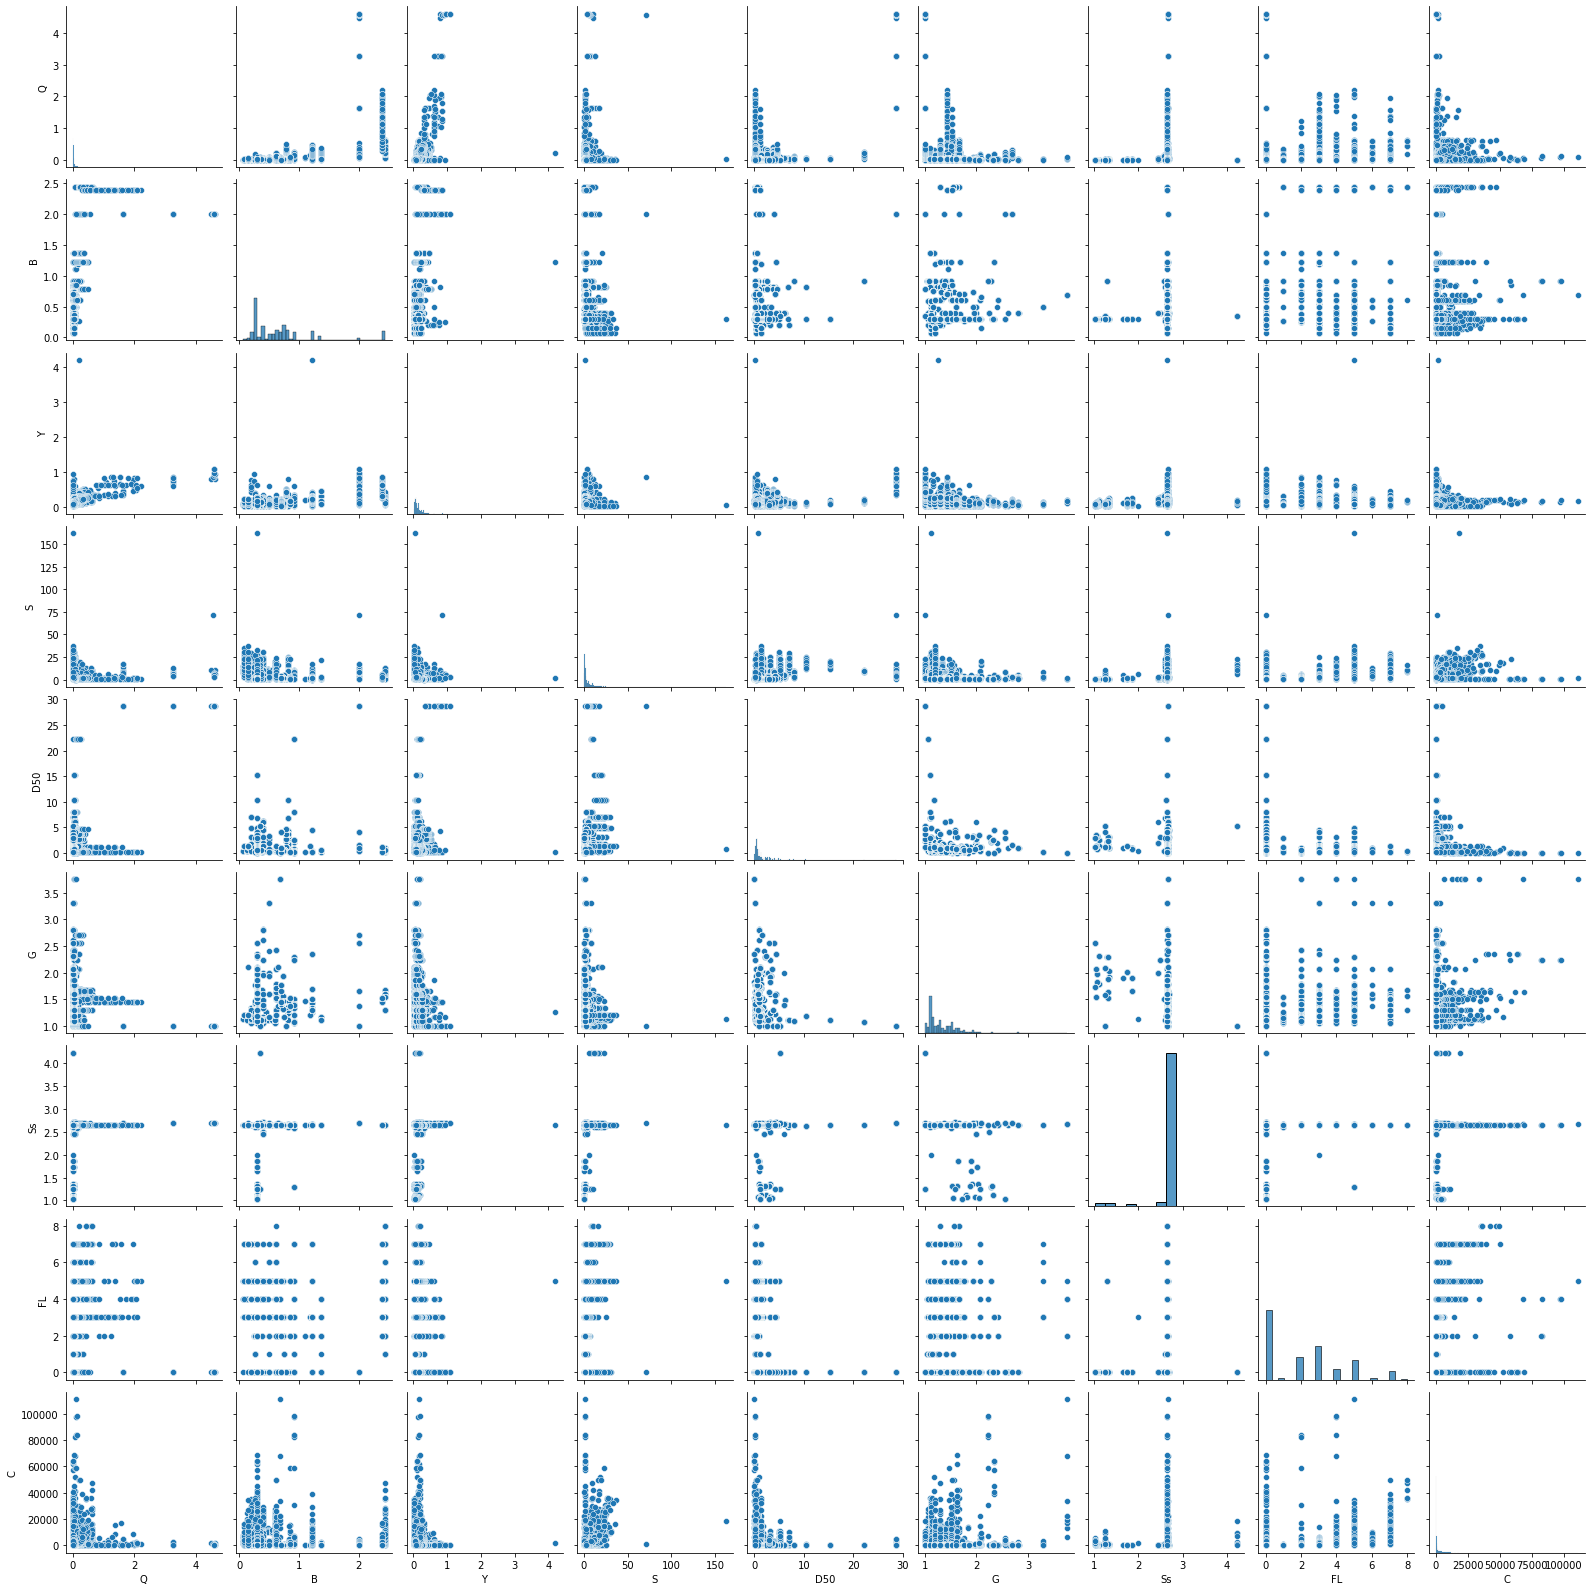

In [ ]:
#Matriz de dispersión - Tarda mucho en producirse

sns.pairplot(BDFLXY)

# 2.APRENDIZAJE SUPERVISADO- VARIABLE 'Concentración'

In [ ]:
BDFLX=BDFLXY.drop(['FL','C'],axis='columns')
BDFLX

,Q,B,Y,S,D50,G,Ss
0,0.036,0.305,0.131,2.50,0.105,1.27,2.65
1,0.036,0.305,0.140,2.20,0.105,1.27,2.65
2,0.028,0.305,0.119,2.30,0.105,1.27,2.65
3,0.028,0.305,0.131,1.70,0.105,1.27,2.65
4,0.025,0.305,0.119,2.10,0.105,1.27,2.65
...,...,...,...,...,...,...,...
7022,0.030,0.500,0.115,1.80,0.180,3.30,2.65
7023,0.030,0.500,0.092,3.50,0.180,3.30,2.65
7024,0.030,0.500,0.086,2.07,0.180,3.30,2.65
7025,0.018,0.500,0.040,8.00,0.180,3.30,2.65


In [ ]:
BDFLY=BDFLXY.drop(['Q','B','Y','S','D50','G','Ss','FL'],axis='columns')
BDFLY

,C
0,6600.0
1,4300.0
2,7000.0
3,4500.0
4,4700.0
...,...
7022,500.0
7023,1007.0
7024,1975.0
7025,3240.0


             Q      B      Y          S    D50      G     Ss     FL          C
Q    1.000e+00  0.519  0.602 -3.983e-04  0.510 -0.048  0.074  0.028 -4.969e-05
B    5.194e-01  1.000  0.418 -1.887e-01  0.092  0.087  0.165  0.060 -5.576e-02
Y    6.024e-01  0.418  1.000 -2.381e-01  0.228 -0.046  0.073 -0.073 -1.181e-01
S   -3.983e-04 -0.189 -0.238  1.000e+00  0.219 -0.281  0.173  0.243  4.542e-01
D50  5.102e-01  0.092  0.228  2.187e-01  1.000 -0.148 -0.014 -0.284 -9.808e-02
G   -4.788e-02  0.087 -0.046 -2.806e-01 -0.148  1.000 -0.361 -0.104  1.536e-02
Ss   7.402e-02  0.165  0.073  1.731e-01 -0.014 -0.361  1.000  0.226  7.578e-02
FL   2.777e-02  0.060 -0.073  2.431e-01 -0.284 -0.104  0.226  1.000  3.411e-01
C   -4.969e-05 -0.056 -0.118  4.542e-01 -0.098  0.015  0.076  0.341  1.000e+00


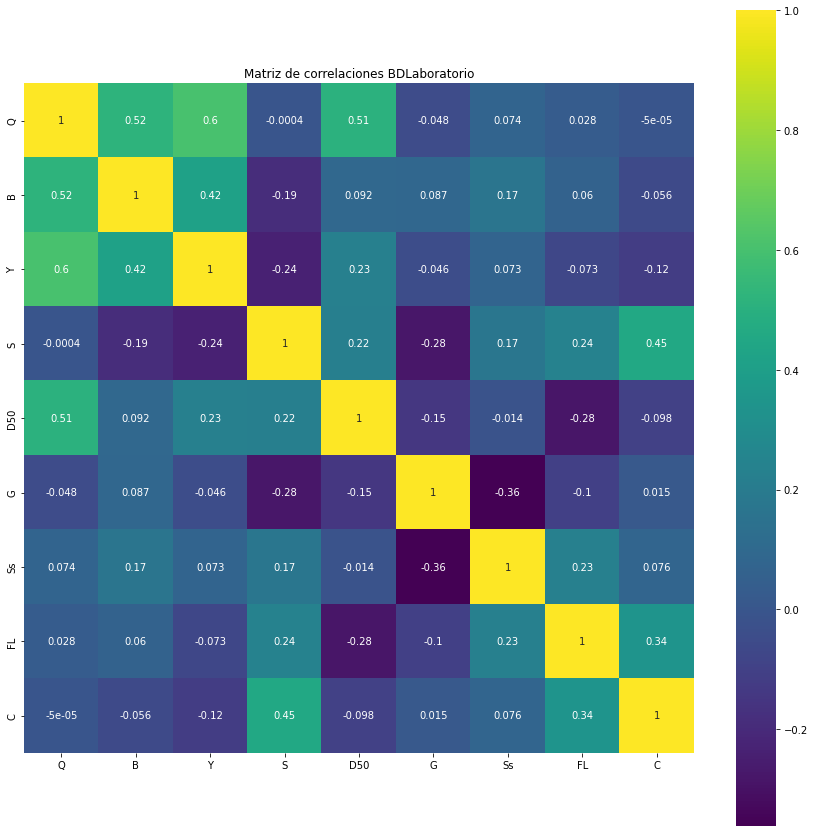

In [ ]:
#Matriz de correlación

corr_BDFLXY=BDFLXY.corr()
print(corr_BDFLXY)
plt.figure(figsize=(15,15))
ax=sns.heatmap(corr_BDFLXY,vmax=1,square=True,annot=True,cmap='viridis')
plt.title('Matriz de correlaciones BDLaboratorio')
plt.savefig("Correlaciones_BDLaboratorio.jpg")

##  2.1.MODELACION BASE

Se realiza una evaluación de todos los modelos de clasificación supervisada y se calculan diferentes métricas(r2,MSE,MAE). Finalmente se grafica para comparar

###**2.1.1 Comparación de modelos -Datos base**

###R²

In [ ]:
#Plantilla regresion

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [ ]:
BDFLY

In [ ]:
#Resumen parámetros - Resultados 3a
# métrica:R2
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='r2'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFLX,BDFLY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-1,040.29%(2,749.89)
Ridge:-1,037.28%(2,744.07)
Lasso:-1,034.43%(2,737.09)
ElNet:-619.76%(1,829.03)
KNR:-390.96%(976.64)
DTR:-97.76%(175.16)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-29.39%(43.47)


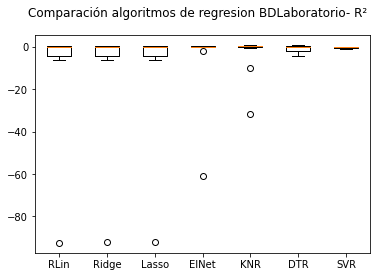

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDLaboratorio- R²")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDLaboratorio- R².jpg")

###MSE

In [ ]:
#Resumen parámetros
# métrica:MSE
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_squared_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFLX,BDFLY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-3,787,552,146.77%(5,924,286,647.17)
Ridge:-3,782,565,764.93%(5,920,404,118.50)
Lasso:-3,780,109,764.13%(5,917,334,446.58)
ElNet:-3,408,075,800.16%(5,918,068,982.04)
KNR:-2,974,170,165.01%(5,667,933,747.32)
DTR:-3,920,159,138.98%(5,741,927,605.99)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-4,544,069,425.68%(6,212,747,105.83)


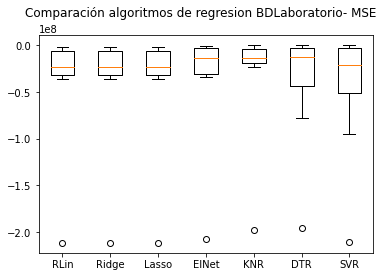

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDLaboratorio- MSE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDLaboratorio- MSE.jpg")

###MAE

In [ ]:
#Resumen parámetros
# métrica: MAE
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_absolute_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFLX,BDFLY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-262,539.92%(113,134.80)
Ridge:-262,214.04%(112,987.64)
Lasso:-261,944.66%(113,081.63)
ElNet:-237,173.64%(125,814.28)
KNR:-156,353.96%(99,709.29)
DTR:-196,873.15%(167,217.92)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-240,763.76%(219,177.19)


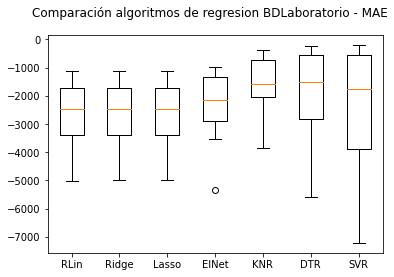

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDLaboratorio - MAE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDLaboratorio- MAE.jpg")

### 2.1.2 Feature selection

### Arboles de decision

In [ ]:
# Arboles de decisión
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#Generar la partición
X_train, X_test, Y_train, Y_test = train_test_split(BDFLX,BDFLY, test_size=0.33, random_state=7)
depth=4
tree=DecisionTreeRegressor(criterion='mse',max_depth=depth)
tree.fit(X_train,Y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


DecisionTreeRegressor(criterion='mse', max_depth=4)

In [ ]:
subset=np.unique(tree.tree_.feature[tree.tree_.feature>=0])
print(f"Variables:{BDFLX.shape[1]}")
print(f"Variables utilizadas:{subset}")
print(f"Training: {tree.score(X_train,Y_train).round(2)}")
print(f"Test: {tree.score(X_test,Y_test).round(2)}")


Variables:7
Variables utilizadas:[0 2 3 4]
Training: 0.82
Test: 0.72


In [ ]:
print(BDFLX.columns[0],BDFLX.columns[2],BDFLX.columns[3],BDFLX.columns[4])

Q Y S D50


Se tiene que las variables recomendadas mediante el método de árboles de dcisióncorresponden al caudal(**Q**), la profundidad de flujo(**Y**), la pendiente (**S**) y el tamaño medio del material(**D50**).


###Eliminación Backward

In [ ]:
import statsmodels.api as sm

BDFLX_1=sm.add_constant(BDFLX) #Se agrega la constante como requisito de la técnica
model=sm.OLS(BDFLY,BDFLX_1).fit()
model.pvalues
# una variable con p mayor a 0.05 es candidata a eliminarse pues no añade información al modelo

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const     1.613e-06
Q         2.796e-18
B         8.058e-02
Y         5.579e-01
S        5.922e-307
D50       5.933e-76
G         3.540e-27
Ss        8.271e-02
dtype: float64

Por tanto, se considera que las variables que solo añaden información al modelo mediante el método de Eliminación Backward son **Q**,**S**,**D50** y **G**. 

### Eliminación recursiva de características

In [ ]:
# Para aplicar la regresión logística se requiere e Label encoder para cambiar el dominio de la variables 0-1.
from sklearn import preprocessing
from sklearn import utils

lab = preprocessing.LabelEncoder()
BDFLY_t = lab.fit_transform(BDFLY)

#view transformed values
print(BDFLY_t)

[3134 2998 3157 ... 2708 2890 1680]


In [ ]:
# Eliminación recursiva de características
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model=LogisticRegression(solver='lbfgs',max_iter=1000)
rfe=RFE(model,n_features_to_select=4)  # dar prioridad a 4 variables
fit=rfe.fit(BDFLX,BDFLY_t)

print(list(BDFLX.columns))
print(f"Numero de  variables: {fit.n_features_}")
print(f"Variables seleccionadas: {fit.support_}")
print(f"Ranking de variables: {fit.ranking_}")

# Tarda mucho en aplicarse

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

['Q', 'B', 'Y', 'S', 'D50', 'G', 'Ss']
Numero de  variables: 4
Variables seleccionadas: [False  True False  True  True  True False]
Ranking de variables: [3 1 4 1 1 1 2]


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Se obtiene que las variables que solo añaden información al modelo mediante el método de eliminación recursiva de características son **B**,**S**,**D50** y **G**. 

## 2.2 MODELACION CON REDUCCION DE VARIABLES

Las variables finalmente seleccionadas corresponden al caudal(**Q**), la pendiente (**S**), el tamaño medio del material(**D50**) y el coeficiente de gradación(**G**).

In [ ]:
BDFLX

,Q,B,Y,S,D50,G,Ss
0,0.036,0.305,0.131,2.50,0.105,1.27,2.65
1,0.036,0.305,0.140,2.20,0.105,1.27,2.65
2,0.028,0.305,0.119,2.30,0.105,1.27,2.65
3,0.028,0.305,0.131,1.70,0.105,1.27,2.65
4,0.025,0.305,0.119,2.10,0.105,1.27,2.65
...,...,...,...,...,...,...,...
7022,0.030,0.500,0.115,1.80,0.180,3.30,2.65
7023,0.030,0.500,0.092,3.50,0.180,3.30,2.65
7024,0.030,0.500,0.086,2.07,0.180,3.30,2.65
7025,0.018,0.500,0.040,8.00,0.180,3.30,2.65


In [ ]:
BDFLX=BDFLX.drop(['B','Ss','Y',],axis='columns')
BDFLX

,Q,S,D50,G
0,0.036,2.50,0.105,1.27
1,0.036,2.20,0.105,1.27
2,0.028,2.30,0.105,1.27
3,0.028,1.70,0.105,1.27
4,0.025,2.10,0.105,1.27
...,...,...,...,...
7022,0.030,1.80,0.180,3.30
7023,0.030,3.50,0.180,3.30
7024,0.030,2.07,0.180,3.30
7025,0.018,8.00,0.180,3.30


In [ ]:
BDFLY

,C
0,6600.0
1,4300.0
2,7000.0
3,4500.0
4,4700.0
...,...
7022,500.0
7023,1007.0
7024,1975.0
7025,3240.0


### 2.2.1 Comparación de modelos - Datos reducidos

###R²

In [ ]:
#Resumen parámetros - - Resultados 3b
# métrica_R²
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='r2'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFLX,BDFLY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-983.39%(2,665.30)
Ridge:-982.16%(2,663.52)
Lasso:-981.78%(2,662.31)
ElNet:-639.41%(1,883.32)
KNR:-361.92%(1,005.32)
DTR:-74.91%(151.81)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-30.10%(44.33)


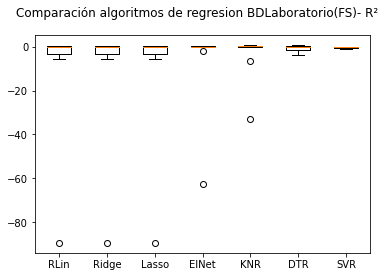

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDLaboratorio(FS)- R²")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDLaboratorio(FS)- R².jpg")

###MSE

In [ ]:
#Resumen parámetros
# métrica:_MSE
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_squared_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFLX,BDFLY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-3,654,403,350.07%(5,767,029,164.92)
Ridge:-3,651,906,891.13%(5,766,734,061.72)
Lasso:-3,651,691,334.08%(5,764,962,319.98)
ElNet:-3,403,185,536.12%(5,908,988,304.25)
KNR:-2,895,027,160.51%(5,673,208,994.03)
DTR:-4,184,122,623.17%(5,807,794,731.23)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-4,542,392,140.79%(6,211,760,050.15)


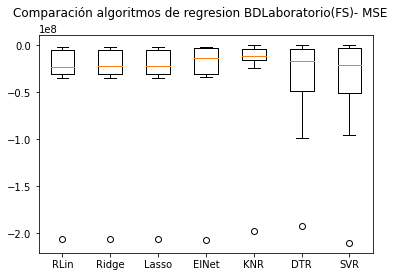

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDLaboratorio(FS)- MSE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDLaboratorio(FS)- MSE.jpg")

###MAE

In [ ]:
#Resumen parámetros
# métrica:MAE
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_absolute_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFLX,BDFLY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-255,563.52%(115,432.90)
Ridge:-255,428.16%(115,341.29)
Lasso:-255,432.46%(115,349.29)
ElNet:-237,423.77%(125,535.65)
KNR:-152,953.07%(100,814.95)
DTR:-183,759.11%(142,946.32)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-240,681.55%(218,882.38)


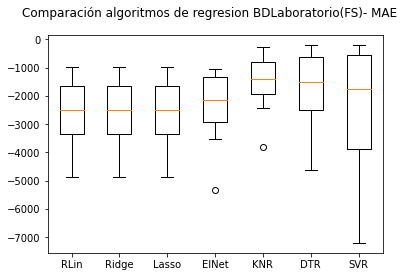

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDLaboratorio(FS)- MAE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDLaboratorio(FS)- MAE.jpg")

##2.3 MODELACION CON VARIABLES ESCALADAS

In [ ]:
BDFLX

,Q,S,D50,G
0,0.036,2.50,0.105,1.27
1,0.036,2.20,0.105,1.27
2,0.028,2.30,0.105,1.27
3,0.028,1.70,0.105,1.27
4,0.025,2.10,0.105,1.27
...,...,...,...,...
7022,0.030,1.80,0.180,3.30
7023,0.030,3.50,0.180,3.30
7024,0.030,2.07,0.180,3.30
7025,0.018,8.00,0.180,3.30


In [ ]:
BDFLY

###Escalamiento

In [ ]:
#escalamiento de la X a valores entre 0 y 1

#from sklearn.preprocessing import MinMaxScaler
#scaler=MinMaxScaler(feature_range=(0,1))
#rescaledX=scaler.fit_transform(BDFLX)
#np.set_printoptions(precision=3)
#print(rescaledX[0:5,:])

#estandarización de la X con media 0 y desviacion de 1
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler().fit(BDFLX)
rescaledX=scaler.fit_transform(BDFLX)
np.set_printoptions(precision=3)
print(rescaledX[0:5,:])

#normalizacion de la X a valores entre 0 y 1
#from sklearn.preprocessing import Normalizer
#scaler=Normalizer().fit(BDFLX)
#rescaledX=scaler.transform(BDFLX)
#np.set_printoptions(precision=3)
#print(rescaledX[0:5,:])

[[-0.197 -0.329 -0.459 -0.294]
 [-0.196 -0.383 -0.459 -0.294]
 [-0.221 -0.365 -0.459 -0.294]
 [-0.224 -0.471 -0.459 -0.294]
 [-0.232 -0.4   -0.459 -0.294]]


###2.3.1 Comparación de modelos - Datos reducidos y reescalados

###R²


In [ ]:
#Resumen parámetros - - Resultados 3c
# métrica: r2
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='r2'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,rescaledX,BDFLY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-983.39%(2,665.30)
Ridge:-983.47%(2,666.01)
Lasso:-983.12%(2,665.45)
ElNet:-1,347.60%(3,900.94)
KNR:-1,047.76%(2,774.75)
DTR:-84.97%(135.90)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-32.10%(44.55)


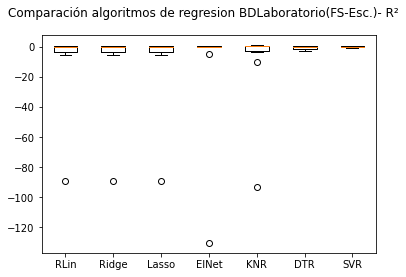

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDLaboratorio(FS-Esc.)- R²")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDLaboratorio(FS-Esc.)- R².jpg")

###MSE

In [ ]:
#Resumen parámetros
# métrica: MSE
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_squared_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,rescaledX,BDFLY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-3,654,403,350.07%(5,767,029,164.92)
Ridge:-3,653,689,036.15%(5,767,075,369.11)
Lasso:-3,653,073,648.94%(5,766,442,621.93)
ElNet:-3,533,836,495.74%(5,840,410,387.27)
KNR:-3,874,645,024.02%(5,811,081,815.81)
DTR:-3,782,552,660.35%(5,566,776,369.55)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-4,594,312,479.14%(6,207,983,158.05)


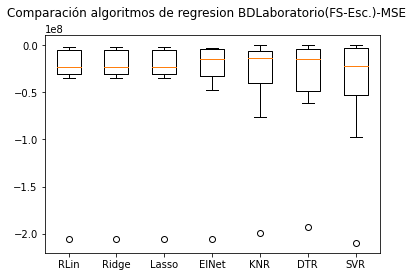

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDLaboratorio(FS-Esc.)-MSE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDLaboratorio(FS-Esc.)-MSE.jpg")

###MAE

In [ ]:
#Resumen parámetros
# métrica: MAE
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_absolute_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,rescaledX,BDFLY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-255,563.52%(115,432.90)
Ridge:-255,538.98%(115,409.96)
Lasso:-255,512.09%(115,392.87)
ElNet:-266,406.58%(119,177.97)
KNR:-166,966.76%(101,511.23)
DTR:-186,966.38%(151,735.27)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-245,805.14%(222,159.57)


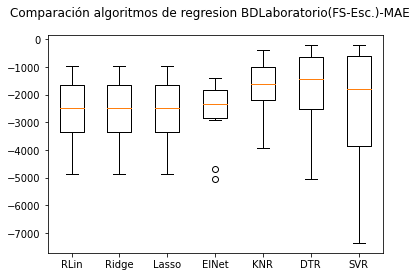

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDLaboratorio(FS-Esc.)-MAE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDLaboratorio(FS-Esc.)-MAE.jpg")

###2.4 MODELACIÓN CON VARIABLES ADIMENSIONALES

Se adimensionalizan las variables buscando un modelo con mejor ajuste, incluyendo un parámetro para la concentración

In [ ]:
BDFL

,Medición,Q,B,Y,S,D50,G,Ss,FL,C,Nombre,Tipo
0,1,0.036,0.305,0.131,2.50,0.105,1.27,2.65,0,6600.0,ABA,Laboratorio
1,2,0.036,0.305,0.140,2.20,0.105,1.27,2.65,0,4300.0,ABA,Laboratorio
2,3,0.028,0.305,0.119,2.30,0.105,1.27,2.65,0,7000.0,ABA,Laboratorio
3,4,0.028,0.305,0.131,1.70,0.105,1.27,2.65,0,4500.0,ABA,Laboratorio
4,5,0.025,0.305,0.119,2.10,0.105,1.27,2.65,0,4700.0,ABA,Laboratorio
...,...,...,...,...,...,...,...,...,...,...,...,...
7022,32,0.030,0.500,0.115,1.80,0.180,3.30,2.65,3,500.0,ZNA,Laboratorio
7023,33,0.030,0.500,0.092,3.50,0.180,3.30,2.65,6,1007.0,ZNA,Laboratorio
7024,34,0.030,0.500,0.086,2.07,0.180,3.30,2.65,5,1975.0,ZNA,Laboratorio
7025,35,0.018,0.500,0.040,8.00,0.180,3.30,2.65,7,3240.0,ZNA,Laboratorio


In [ ]:
# Cálculo de la nueva matriz de variables
BDFLA= pd.DataFrame()
nu=1e-6 # Viscosidad cinematica del agua
BDFLA['AA']=BDFL['B']/(BDFL['D50']/1000)
BDFLA['PA']=BDFL['Y']/(BDFL['D50']/1000)
BDFLA['Ref']=BDFL['Q']/(BDFL['B']*nu)
BDFLA['Res']=(BDFL['D50']/1000)*pow(9.81*BDFL['Y']*BDFL['S']/1000,0.5)/(nu)
BDFLA['EA']=BDFL['Y']*(BDFL['S']/1000)/((BDFL['D50']/1000)*(BDFL['Ss']-1))
BDFLA['Ff']=BDFL['Q']/(BDFL['B']*pow(9.81*BDFL['Y']**3*BDFL['S']/1000,0.5))
BDFLA['Fr']=BDFL['Q']/(BDFL['B']*pow(9.81*BDFL['Y']**3,0.5))
BDFLA['CUA']=BDFL['Q']/(BDFL['B']*(BDFL['D50']/1000)*pow(9.81*BDFL['Y']*BDFL['S']/1000,0.5))
BDFLA['VCA']=nu*pow(9.81*BDFL['Y']*BDFL['S']/1000,0.5)/(9.81*(BDFL['Ss']-1)*(BDFL['D50']/1000)**2)
BDFLA['TPA']=pow(nu,2)/(9.81*(BDFL['Ss']-1)*(BDFL['D50']/1000)**3)
BDFLA['CUA2']=BDFL['Q']**2/(BDFL['B']**2*9.81*(BDFL['Ss']-1)*(BDFL['D50']/1000)**3)
BDFLA['PM']=BDFL['Y']*(BDFL['S']/1000)/(BDFL['D50']/1000)
BDFLA['Frp']=BDFL['Q']/(BDFL['B']*BDFL['Y']*pow(9.81*(BDFL['Ss']-1)*BDFL['D50']/1000,0.5))
BDFLA['Phi']=BDFL['C']*(BDFL['D50']/1000)*BDFL['Q']/(BDFL['B']*BDFL['Y']*pow(9.81*(BDFL['Ss']-1)*(BDFL['D50']/1000)**3,0.5))
BDFLA

,AA,PA,Ref,Res,EA,Ff,Fr,CUA,VCA,TPA,CUA2,PM,Frp,Phi
0,2904.762,1248.571,116570.492,5.954,1.892,15.681,0.784,19579.134,0.318,0.053,7.252e+08,3.121,21.568,142350.418
1,2904.762,1335.238,117442.623,5.776,1.780,15.229,0.714,20333.708,0.308,0.053,7.361e+08,2.938,20.319,87372.560
2,2904.762,1132.381,93052.459,5.438,1.578,15.110,0.725,17109.968,0.290,0.053,4.621e+08,2.604,18.983,132884.068
3,2904.762,1248.571,90219.672,4.910,1.286,14.718,0.607,18376.028,0.262,0.053,4.344e+08,2.123,16.693,75117.295
4,2904.762,1132.381,81465.574,5.197,1.441,13.844,0.634,15676.523,0.277,0.053,3.542e+08,2.378,16.620,78112.223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7022,2777.778,638.889,60000.000,8.111,0.697,11.578,0.491,7397.059,0.086,0.011,3.814e+07,1.150,9.666,4832.932
7023,2777.778,511.111,59600.000,10.117,1.084,11.526,0.682,5891.302,0.107,0.011,3.763e+07,1.789,12.002,12085.794
7024,2777.778,477.778,60800.000,7.522,0.599,16.918,0.770,8082.806,0.080,0.011,3.916e+07,0.989,13.098,25867.800
7025,2777.778,222.222,37000.000,10.085,1.077,16.509,1.477,3668.764,0.107,0.011,1.450e+07,1.778,17.137,55523.139


In [ ]:
BDFLAX=BDFLA.drop(['Phi'],axis='columns')
BDFLAX

,AA,PA,Ref,Res,EA,Ff,Fr,CUA,VCA,TPA,CUA2,PM,Frp
0,2904.762,1248.571,116570.492,5.954,1.892,15.681,0.784,19579.134,0.318,0.053,7.252e+08,3.121,21.568
1,2904.762,1335.238,117442.623,5.776,1.780,15.229,0.714,20333.708,0.308,0.053,7.361e+08,2.938,20.319
2,2904.762,1132.381,93052.459,5.438,1.578,15.110,0.725,17109.968,0.290,0.053,4.621e+08,2.604,18.983
3,2904.762,1248.571,90219.672,4.910,1.286,14.718,0.607,18376.028,0.262,0.053,4.344e+08,2.123,16.693
4,2904.762,1132.381,81465.574,5.197,1.441,13.844,0.634,15676.523,0.277,0.053,3.542e+08,2.378,16.620
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7022,2777.778,638.889,60000.000,8.111,0.697,11.578,0.491,7397.059,0.086,0.011,3.814e+07,1.150,9.666
7023,2777.778,511.111,59600.000,10.117,1.084,11.526,0.682,5891.302,0.107,0.011,3.763e+07,1.789,12.002
7024,2777.778,477.778,60800.000,7.522,0.599,16.918,0.770,8082.806,0.080,0.011,3.916e+07,0.989,13.098
7025,2777.778,222.222,37000.000,10.085,1.077,16.509,1.477,3668.764,0.107,0.011,1.450e+07,1.778,17.137


In [ ]:
BDFLAY=BDFLA.filter(['Phi'])
BDFLAY

,Phi
0,142350.418
1,87372.560
2,132884.068
3,75117.295
4,78112.223
...,...
7022,4832.932
7023,12085.794
7024,25867.800
7025,55523.139


###2.4.1 Comparación de modelos - Variables adimensionales

###R²

In [ ]:
#Resumen parámetros - Resultados 3d
# métrica: r2
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='r2'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFLAX,BDFLAY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-12,314.46%(26,424.02)
Ridge:-3,795.63%(10,139.25)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.37459e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.37002e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.38755e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.3869e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditi

Lasso:-10,789.45%(22,301.67)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.611e+13, tolerance: 1.284e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.193e+13, tolerance: 1.281e+10
  model = cd_fast.enet_coordinate_descent(


ElNet:-3,165.00%(8,708.73)
KNR:-5,554.11%(15,803.16)
DTR:-184.72%(658.78)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-39.37%(58.28)


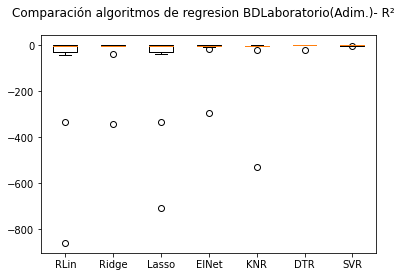

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDLaboratorio(Adim.)- R²")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDLaboratorio(Adim.)- R².jpg")

###MSE

In [ ]:
#Resumen parámetros
# métrica: MSE
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_squared_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFLAX,BDFLAY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-1,730,494,637,523,990.50%(5,190,297,634,811,317.00)
Ridge:-5,060,933,685,438.51%(14,002,475,479,014.99)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.37459e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.37002e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.38755e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.3869e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditi

Lasso:-1,427,039,076,901,563.50%(4,279,933,079,861,703.00)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.611e+13, tolerance: 1.284e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.193e+13, tolerance: 1.281e+10
  model = cd_fast.enet_coordinate_descent(


ElNet:-12,449,422,136,807.24%(35,777,521,112,101.90)
KNR:-2,428,557,516,684.59%(4,770,511,652,068.38)
DTR:-2,123,157,265,006.86%(5,580,635,780,532.73)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

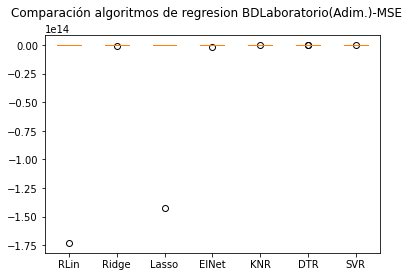

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDLaboratorio(Adim.)-MSE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDLaboratorio(Adim.)-MSE.jpg")

###MAE

In [ ]:
#Resumen parámetros
# métrica: MAE
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_absolute_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFLAX,BDFLAY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-24,504,135.33%(63,700,750.72)
Ridge:-4,349,077.19%(3,432,775.03)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.37459e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.37002e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.38755e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.3869e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditi

Lasso:-22,516,015.15%(57,753,514.06)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.611e+13, tolerance: 1.284e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.193e+13, tolerance: 1.281e+10
  model = cd_fast.enet_coordinate_descent(


ElNet:-4,957,699.22%(4,379,233.56)
KNR:-4,004,321.09%(2,494,277.84)
DTR:-1,978,245.05%(2,284,455.56)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-3,499,632.78%(3,249,542.39)


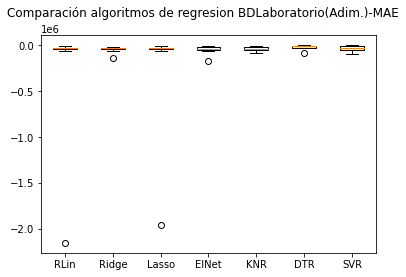

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresion BDLaboratorio(Adim.)-MAE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Comparación algoritmos de regresion BDLaboratorio(Adim.)-MAE.jpg")

###2.4.2Feature Selection

### Arboles de decision

In [ ]:
# Arboles de decisión
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#Generar la partición
X_train, X_test, Y_train, Y_test = train_test_split(BDFLAX,BDFLAY, test_size=0.33, random_state=7)
depth=3
tree=DecisionTreeRegressor(criterion='mse',max_depth=depth)
tree.fit(X_train,Y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


DecisionTreeRegressor(criterion='mse', max_depth=3)

In [ ]:
subset=np.unique(tree.tree_.feature[tree.tree_.feature>=0])
print(f"Variables:{BDFLAX.shape[1]}")
print(f"Variables utilizadas:{subset}")
print(f"Training: {tree.score(X_train,Y_train).round(2)}")
print(f"Test: {tree.score(X_test,Y_test).round(2)}")

Variables:13
Variables utilizadas:[ 0  6  7 11 12]
Training: 0.84
Test: -0.33


In [ ]:
print(BDFLAX.columns[0],BDFLAX.columns[4],BDFLAX.columns[6],BDFLAX.columns[7],BDFLAX.columns[11])

AA EA Fr CUA PM


Se tiene que las variables recomendadas por el método de árboles de decisión son Altura aparente(**AA**),Esfuerzo aparente(**EA**), Número de Froude(**Fr**),Caudal unitario adimensional(**CUA**) y Parámetro de movilidad (**PMA**). 

###Eliminación Backward

In [ ]:
import statsmodels.api as sm

BDFLAX_1=sm.add_constant(BDFLAX)
model=sm.OLS(BDFLAY,BDFLAX_1).fit()
model.pvalues
# una variable con p mayor a 0.05 es candidata a eliminarse pues no añade información al modelo

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const    1.064e-21
AA       3.532e-09
PA       1.175e-47
Ref      9.155e-01
Res      1.512e-01
EA       8.931e-08
Ff       1.040e-02
Fr       3.529e-67
CUA      7.916e-12
VCA      0.000e+00
TPA      0.000e+00
CUA2     3.478e-04
PM       1.232e-04
Frp      3.486e-02
dtype: float64

Por tanto, según el método de eliminación Backward se considera que todas las variables aportan información al modelo menos  **Ref** y **Res**.

###Eliminación recursiva de características

In [ ]:
BDFLAX

,AA,PA,Ref,Res,EA,Ff,Fr,CUA,VCA,TPA,CUA2,PM,Frp
0,2904.762,1248.571,116570.492,5.954,1.892,15.681,0.784,19579.134,0.318,0.053,7.252e+08,3.121,21.568
1,2904.762,1335.238,117442.623,5.776,1.780,15.229,0.714,20333.708,0.308,0.053,7.361e+08,2.938,20.319
2,2904.762,1132.381,93052.459,5.438,1.578,15.110,0.725,17109.968,0.290,0.053,4.621e+08,2.604,18.983
3,2904.762,1248.571,90219.672,4.910,1.286,14.718,0.607,18376.028,0.262,0.053,4.344e+08,2.123,16.693
4,2904.762,1132.381,81465.574,5.197,1.441,13.844,0.634,15676.523,0.277,0.053,3.542e+08,2.378,16.620
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7022,2777.778,638.889,60000.000,8.111,0.697,11.578,0.491,7397.059,0.086,0.011,3.814e+07,1.150,9.666
7023,2777.778,511.111,59600.000,10.117,1.084,11.526,0.682,5891.302,0.107,0.011,3.763e+07,1.789,12.002
7024,2777.778,477.778,60800.000,7.522,0.599,16.918,0.770,8082.806,0.080,0.011,3.916e+07,0.989,13.098
7025,2777.778,222.222,37000.000,10.085,1.077,16.509,1.477,3668.764,0.107,0.011,1.450e+07,1.778,17.137


In [ ]:
# Para aplicar la regresión logística se requiere e Label encoder para cambiar el dominio de la variables 0-1.
from sklearn import preprocessing
from sklearn import utils

lab = preprocessing.LabelEncoder()
BDFLAY_t = lab.fit_transform(BDFLAY)

#view transformed values
print(BDFLAY_t)

[1149 1041 1081 ... 1049   72  576]


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Eliminación recursiva de características
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model=LogisticRegression(solver='lbfgs',max_iter=1000)
rfe=RFE(model,n_features_to_select=4)  # dar prioridad a 4 variables
fit=rfe.fit(BDFLAX,BDFLAY_t)

print(list(BDFLAX.columns))
print(f"Numero de  variables: {fit.n_features_}")
print(f"Variables seleccionadas: {fit.support_}")
print(f"Ranking de variables: {fit.ranking_}")

# Tarda mucho en aplicarse

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

['AA', 'PA', 'Ref', 'Res', 'EA', 'Ff', 'Fr', 'CUA', 'VCA', 'TPA', 'CUA2', 'PM', 'Frp']
Numero de  variables: 4
Variables seleccionadas: [ True False  True False False False False  True False False  True False
 False]
Ranking de variables: [ 1  2  1  3  7  5 10  1  9  8  1  6  4]


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Se obtiene que las 4 variables que mas añaden información al modelo  según la eliminación recursiva de características son: **AA**,**Ref**,**CUA** y **CUA2**.

###2.4.3 Comparación de modelos - Variables adimensionales reducidas

Las variables seleccionadas como mas importantes son: **AA**,**EA**,**Fr**,**CUA** y **PM**.

In [ ]:
BDFLAX

,AA,PA,Ref,Res,EA,Ff,Fr,CUA,VCA,TPA,CUA2,PM,Frp
0,2904.762,1248.571,116570.492,5.954,1.892,15.681,0.784,19579.134,0.318,0.053,7.252e+08,3.121,21.568
1,2904.762,1335.238,117442.623,5.776,1.780,15.229,0.714,20333.708,0.308,0.053,7.361e+08,2.938,20.319
2,2904.762,1132.381,93052.459,5.438,1.578,15.110,0.725,17109.968,0.290,0.053,4.621e+08,2.604,18.983
3,2904.762,1248.571,90219.672,4.910,1.286,14.718,0.607,18376.028,0.262,0.053,4.344e+08,2.123,16.693
4,2904.762,1132.381,81465.574,5.197,1.441,13.844,0.634,15676.523,0.277,0.053,3.542e+08,2.378,16.620
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7022,2777.778,638.889,60000.000,8.111,0.697,11.578,0.491,7397.059,0.086,0.011,3.814e+07,1.150,9.666
7023,2777.778,511.111,59600.000,10.117,1.084,11.526,0.682,5891.302,0.107,0.011,3.763e+07,1.789,12.002
7024,2777.778,477.778,60800.000,7.522,0.599,16.918,0.770,8082.806,0.080,0.011,3.916e+07,0.989,13.098
7025,2777.778,222.222,37000.000,10.085,1.077,16.509,1.477,3668.764,0.107,0.011,1.450e+07,1.778,17.137


In [ ]:
# X y Y reducidos
BDFLAX=BDFLA.drop(['PA','Ref','Res','Ff','CUA2','VCA','TPA','Frp','Phi'],axis='columns')
BDFLAX

,AA,EA,Fr,CUA,PM
0,2904.762,1.892,0.784,19579.134,3.121
1,2904.762,1.780,0.714,20333.708,2.938
2,2904.762,1.578,0.725,17109.968,2.604
3,2904.762,1.286,0.607,18376.028,2.123
4,2904.762,1.441,0.634,15676.523,2.378
...,...,...,...,...,...
7022,2777.778,0.697,0.491,7397.059,1.150
7023,2777.778,1.084,0.682,5891.302,1.789
7024,2777.778,0.599,0.770,8082.806,0.989
7025,2777.778,1.077,1.477,3668.764,1.778


In [ ]:
BDFLAY

,Phi
0,142350.418
1,87372.560
2,132884.068
3,75117.295
4,78112.223
...,...
7022,4832.932
7023,12085.794
7024,25867.800
7025,55523.139


###R²

In [ ]:
#Resumen parámetros - Resultados 3e
# métrica_R²
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='r2'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFLAX,BDFLAY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-10,405.56%(27,933.99)
Ridge:-10,663.79%(28,946.18)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.307e+13, tolerance: 1.307e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+13, tolerance: 1.284e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.766e+13, tolerance: 1.317e+10

Lasso:-10,283.16%(28,117.32)
ElNet:-2,487.57%(6,877.15)
KNR:-27,071.68%(78,208.07)
DTR:-104.96%(294.17)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-39.55%(58.76)


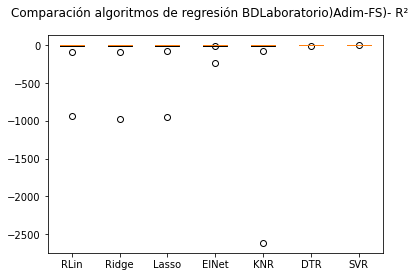

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresión BDLaboratorio)Adim-FS)- R²")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Regresion BDLaboratorio(Adim-FS)- R².jpg")

###MSE

In [ ]:
#Resumen parámetros
# métrica MSE
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_squared_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFLAX,BDFLAY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-2,266,607,104,675.51%(4,658,949,671,181.61)
Ridge:-2,264,701,168,182.96%(4,659,759,979,879.32)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.307e+13, tolerance: 1.307e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+13, tolerance: 1.284e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.766e+13, tolerance: 1.317e+10

Lasso:-2,262,506,118,805.83%(4,661,326,158,449.69)
ElNet:-2,257,836,345,352.84%(4,799,272,340,533.27)
KNR:-2,807,407,727,009.20%(5,723,132,578,891.80)
DTR:-4,048,804,024,930.46%(7,540,241,876,134.79)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-2,716,314,258,296.99%(6,137,237,259,109.18)


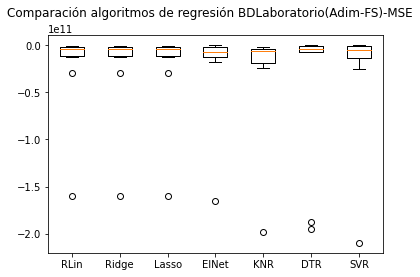

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresión BDLaboratorio(Adim-FS)-MSE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Regresion BDLaboratorio(Adim-FS)- MSE.jpg")

###MAE

In [ ]:
#Resumen parámetros
# métrica:mae
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_absolute_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,BDFLAX,BDFLAY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-4,616,114.52%(2,051,519.38)
Ridge:-4,601,570.86%(2,056,194.29)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.307e+13, tolerance: 1.307e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+13, tolerance: 1.284e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.766e+13, tolerance: 1.317e+10

Lasso:-4,587,631.70%(2,061,011.99)
ElNet:-4,091,773.41%(2,476,175.62)
KNR:-5,301,537.31%(2,687,233.57)
DTR:-2,097,875.72%(2,396,510.57)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-3,498,883.36%(3,249,678.04)


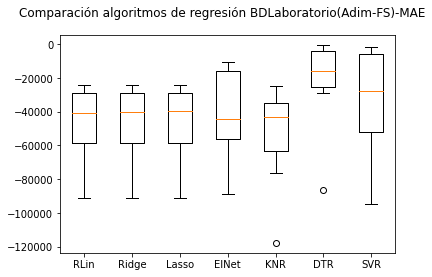

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresión BDLaboratorio(Adim-FS)-MAE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Regresion BDLaboratorio(Adim-FS)- MAE.jpg")

###2.4.4 Comparación de modelos - Variable adimensionales reducidas escaladas

###Escalamiento

In [ ]:
#escalamiento de la X a valores entre 0 y 1

#from sklearn.preprocessing import MinMaxScaler
#scaler=MinMaxScaler(feature_range=(0,1))
#rescaledX=scaler.fit_transform(BDFLAX)
#np.set_printoptions(precision=3)
#print(rescaledX[0:5,:])

#estandarización de la X con media 0 y desviacion de 1
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler().fit(BDFLAX)
rescaledX=scaler.fit_transform(BDFLAX)
np.set_printoptions(precision=3)
print(rescaledX[0:5,:])

#normalizacion de la X a valores entre 0 y 1
#from sklearn.preprocessing import Normalizer
#scaler=Normalizer().fit(BDFLAX)
#rescaledX=scaler.transform(BDFLAX)
#np.set_printoptions(precision=3)
#print(rescaledX[0:5,:])

[[ 0.259  2.201  0.236  1.062  2.198]
 [ 0.259  2.036  0.075  1.115  2.035]
 [ 0.259  1.739  0.099  0.887  1.739]
 [ 0.259  1.308 -0.173  0.976  1.31 ]
 [ 0.259  1.536 -0.109  0.785  1.537]]


###R²

In [ ]:
#Resumen parámetros - Resultados 3f
# métrica: r2
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='r2'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,rescaledX,BDFLAY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-10,405.56%(27,933.99)
Ridge:-10,541.22%(28,574.50)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.133e+13, tolerance: 1.307e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.876e+13, tolerance: 1.284e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.134e+13, tolerance: 1.317e+10

Lasso:-10,280.32%(28,111.36)
ElNet:-4,694.26%(12,867.66)
KNR:-17.38%(99.86)
DTR:-100.44%(293.78)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-32.96%(45.02)


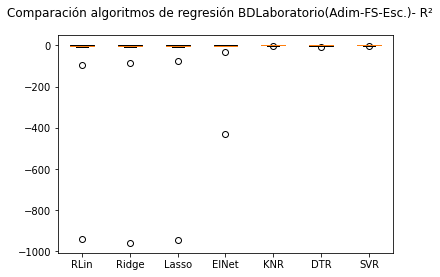

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresión BDLaboratorio(Adim-FS-Esc.)- R²")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Regresion BDLaboratorio(Adim-FS-Esc.)- R².jpg")

###MSE

In [ ]:
#Resumen parámetros
# métrica MSE
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_squared_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,rescaledX,BDFLAY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-2,266,607,104,690.11%(4,658,949,671,216.42)
Ridge:-2,264,666,641,467.29%(4,659,619,515,749.92)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.133e+13, tolerance: 1.307e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.876e+13, tolerance: 1.284e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.134e+13, tolerance: 1.317e+10

Lasso:-2,262,514,926,714.83%(4,661,421,226,817.01)
ElNet:-2,187,317,658,073.61%(4,917,366,636,057.16)
KNR:-1,980,497,666,531.32%(4,979,524,106,324.98)
DTR:-4,063,548,696,575.95%(7,567,940,256,242.47)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-2,711,518,754,717.77%(6,134,494,457,138.04)


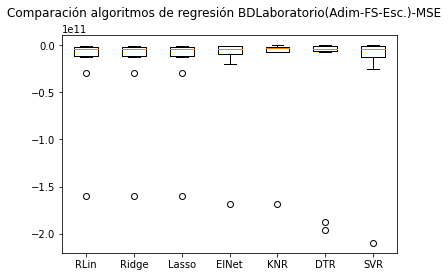

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresión BDLaboratorio(Adim-FS-Esc.)-MSE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Regresion BDLaboratorio(Adim-FS-Esc.)- MSE.jpg")

###MAE

In [ ]:
#Resumen parámetros
# métrica:mae
models =[]
models.append(('RLin',LinearRegression()))
models.append(('Ridge',Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElNet',ElasticNet()))
models.append(('KNR',KNeighborsRegressor()))
models.append(('DTR',DecisionTreeRegressor()))
models.append(('SVR',SVR()))

results=[]
names=[]
scoring='neg_mean_absolute_error'
for name, model in models:
  kfold=KFold(n_splits=10)
  cv_results=cross_val_score(model,rescaledX,BDFLAY,cv=kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f"{name}:{cv_results.mean()*100.0:,.2f}%({cv_results.std()*100.0:,.2f})")

RLin:-4,616,114.52%(2,051,519.38)
Ridge:-4,603,633.02%(2,055,491.21)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.133e+13, tolerance: 1.307e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.876e+13, tolerance: 1.284e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.134e+13, tolerance: 1.317e+10

Lasso:-4,587,522.06%(2,061,084.32)
ElNet:-4,056,535.93%(2,274,740.98)
KNR:-1,910,930.74%(2,070,663.83)
DTR:-2,113,872.96%(2,422,478.33)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVR:-3,472,840.27%(3,242,076.78)


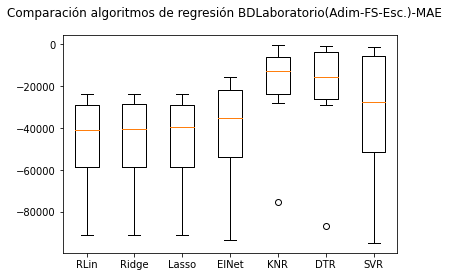

<Figure size 432x288 with 0 Axes>

In [ ]:
#Comparación gráfica
fig=plt.figure()
fig.suptitle("Comparación algoritmos de regresión BDLaboratorio(Adim-FS-Esc.)-MAE")
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
plt.savefig("Regresion BDLaboratorio(Adim-FS-Esc.)- MAE.jpg")